# WCWH Rollout Preparation
Working to get the beacons ready for their next adventure. 

In [21]:
import warnings
warnings.filterwarnings('ignore')

# Setup
Here we define some important variables and set up the notebook.

In [22]:
import os
import sys
sys.path.append('../')

import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
from src.visualization import visualize

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Constant Variables

In [23]:
beacons = [1,2,4,5,6,7,8,9,10,11,12,14,15,16,19,21,25,26,28,29]
raw_data_dir = "/Users/hagenfritz/Projects/utx000/data/raw/wcwh_pilot/beacon/"

## Functions

In [24]:
def import_beacon_data(beacon_list, start_time=datetime(2021,5,1), end_time=datetime(2022,1,1), resample_rate=5, data_dir="/Users/hagenfritz/Projects/utx000/data/raw/wcwh_pilot/beacon/"):
    """imports beacon data"""
    data = pd.DataFrame()
    for beacon in beacon_list:
        number = f'{beacon:02}'
        data_by_beacon = pd.DataFrame()
        print(beacon)
        try:
            for file in os.listdir(f"{raw_data_dir}B{number}/DATA/"):
                if file[-1] == "v":
                    print(file)
                    temp = pd.read_csv(f"{raw_data_dir}B{number}/DATA/{file}")
                    if len(temp) > 0:
                        data_by_beacon = data_by_beacon.append(temp)
            if len(data_by_beacon) > 0:
                data_by_beacon["Timestamp"] = pd.to_datetime(data_by_beacon["Timestamp"])
                data_by_beacon.dropna(subset=["Timestamp"],inplace=True)
                data_by_beacon.set_index("Timestamp",inplace=True)
                data_by_beacon.sort_index(inplace=True)
                data_by_beacon = data_by_beacon.sort_index()[start_time:end_time]
                data_by_beacon = data_by_beacon.resample(f"{resample_rate}T").mean()
                data_by_beacon["beacon"] = int(number)
                data = data.append(data_by_beacon)
        except FileNotFoundError:
            print(f"No files found for beacon {beacon}.")
            
    data['temperature_c'] = data[['T_CO','T_NO2']].mean(axis=1)
    data['rh'] = data[['RH_CO','RH_NO2']].mean(axis=1)
    data.drop(["eCO2","Visible","Infrared","Temperature [C]","Relative Humidity","PM_N_0p5","T_CO","T_NO2","RH_CO","RH_NO2"],axis="columns",inplace=True)
    data = data[[column for column in data.columns if "1" not in column and "4" not in column]]
    data.reset_index(inplace=True)
    data.columns = ["timestamp","tvoc","lux","co","no2","pm2p5_number","pm2p5_mass","co2","beacon","temperature_c","rh"]
    data["co"] /= 1000
    return data

# Beacon Inspection
Prior to calibrating, I want to make sure the beacons are working well.

## Importing Beacon Data

In [25]:
raw_data = import_beacon_data(beacons)
raw_data.head()

1
b01_2021-04-17.csv
b01_2021-04-16.csv
b01_2021-04-28.csv
b01_2021-04-29.csv
b01_2021-05-19.csv
b01_2021-05-18.csv
b01_2021-05-20.csv
b01_2021-05-08.csv
b01_2021-05-09.csv
b01_2021-05-21.csv
b01_2021-05-13.csv
b01_2021-05-07.csv
b01_2021-05-06.csv
b01_2021-05-12.csv
b01_2021-05-04.csv
b01_2021-05-10.csv
b01_2021-05-11.csv
b01_2021-05-05.csv
b01_2021-05-01.csv
b01_2021-05-15.csv
b01_2021-05-14.csv
b01_2021-05-16.csv
b01_2021-05-02.csv
b01_2021-05-03.csv
b01_2021-05-17.csv
b01_2021-04-24.csv
b01_2021-04-30.csv
b01_2021-04-18.csv
b01_2021-04-19.csv
b01_2021-04-25.csv
b01_2021-04-27.csv
b01_2021-04-26.csv
b01_2021-04-22.csv
b01_2021-04-23.csv
b01_2021-04-21.csv
b01_2021-04-20.csv
2
b02_2021-05-27.csv
b02_2021-05-26.csv
b02_2021-05-18.csv
b02_2021-05-24.csv
b02_2021-05-30.csv
b02_2021-05-31.csv
b02_2021-05-25.csv
b02_2021-05-19.csv
b02_2021-05-21.csv
b02_2021-05-09.csv
b02_2021-05-08.csv
b02_2021-05-20.csv
b02_2021-05-22.csv
b02_2021-05-23.csv
b02_2021-06-01.csv
b02_2021-06-02.csv
b02_2021

b12_2021-04-19.csv
b12_2021-04-25.csv
b12_2021-04-30.csv
b12_2021-04-24.csv
b12_2021-04-18.csv
b12_2021-04-26.csv
b12_2021-04-27.csv
14
15
b15_2021-04-29.csv
b15_2021-04-28.csv
b15_2021-04-17.csv
b15_2021-06-02.csv
b15_2021-06-01.csv
b15_2021-05-22.csv
b15_2021-05-23.csv
b15_2021-05-21.csv
b15_2021-05-09.csv
b15_2021-05-08.csv
b15_2021-05-20.csv
b15_2021-05-18.csv
b15_2021-05-30.csv
b15_2021-05-24.csv
b15_2021-05-25.csv
b15_2021-05-31.csv
b15_2021-05-19.csv
b15_2021-05-27.csv
b15_2021-05-26.csv
b15_2021-05-03.csv
b15_2021-05-17.csv
b15_2021-05-16.csv
b15_2021-05-02.csv
b15_2021-05-14.csv
b15_2021-05-28.csv
b15_2021-05-29.csv
b15_2021-05-01.csv
b15_2021-05-15.csv
b15_2021-05-11.csv
b15_2021-05-05.csv
b15_2021-05-04.csv
b15_2021-05-10.csv
b15_2021-05-06.csv
b15_2021-05-12.csv
b15_2021-05-13.csv
b15_2021-05-07.csv
b15_2021-04-20.csv
b15_2021-04-21.csv
b15_2021-04-23.csv
b15_2021-04-22.csv
b15_2021-04-26.csv
b15_2021-04-27.csv
b15_2021-04-25.csv
b15_2021-04-19.csv
b15_2021-04-18.csv
b15_20

,timestamp,tvoc,lux,co,no2,pm2p5_number,pm2p5_mass,co2,beacon,temperature_c,rh
0,2021-05-01 00:00:00,532.2,0.0,-2.9784,106.4,5.178191,0.68611,228.216016,1,26.5,51.0
1,2021-05-01 00:05:00,527.6,0.0,-2.6962,106.8,5.178191,0.68611,232.161481,1,26.5,51.0
2,2021-05-01 00:10:00,524.0,0.0,-2.8936,106.0,5.178191,0.68611,221.592950,1,26.5,51.0
3,2021-05-01 00:15:00,525.6,0.0,-2.8390,107.2,5.178191,0.68611,239.283829,1,26.5,51.0
4,2021-05-01 00:20:00,524.4,0.0,-2.8178,107.6,5.178191,0.68611,206.203730,1,26.5,51.0


## Examining Data Availabaility
Number of data points per beacon (including `NaN` measurement from some sensors).

In [26]:
for beacon in raw_data["beacon"].unique():
    data_by_beacon = raw_data[raw_data["beacon"] == beacon]
    #data_by_beacon.dropna(inplace=True)
    print(f"Beacon {beacon}:\t{len(data_by_beacon)}")

Beacon 1:	5871
Beacon 2:	9322
Beacon 4:	9322
Beacon 5:	9322
Beacon 6:	6576
Beacon 7:	9323
Beacon 8:	1621
Beacon 9:	9324
Beacon 10:	9324
Beacon 11:	6567
Beacon 12:	9324
Beacon 15:	9324
Beacon 16:	9324
Beacon 19:	3070
Beacon 21:	9324
Beacon 25:	6339
Beacon 26:	6558
Beacon 28:	5692
Beacon 29:	5692


## Visualizing

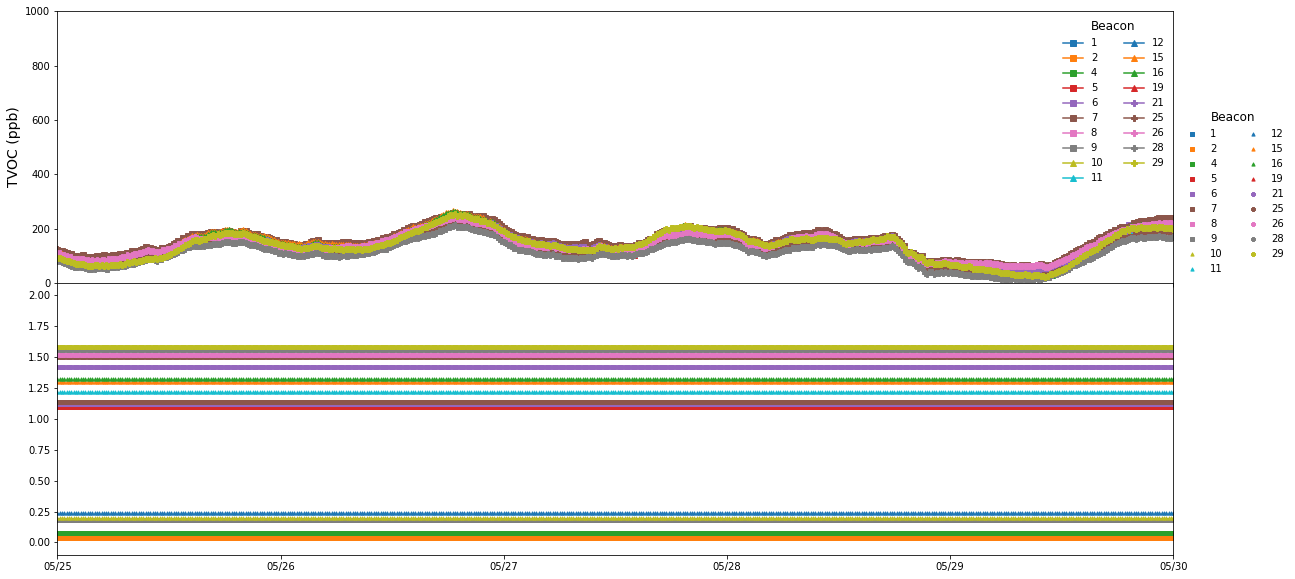

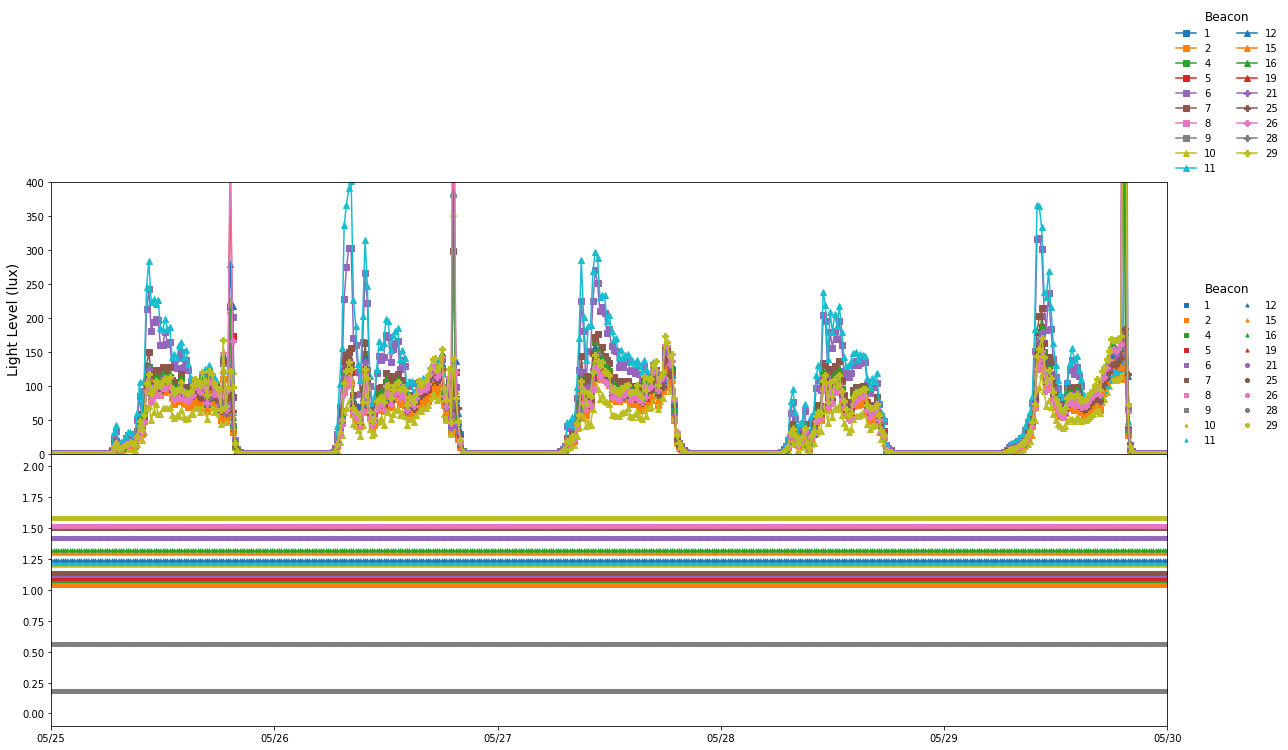

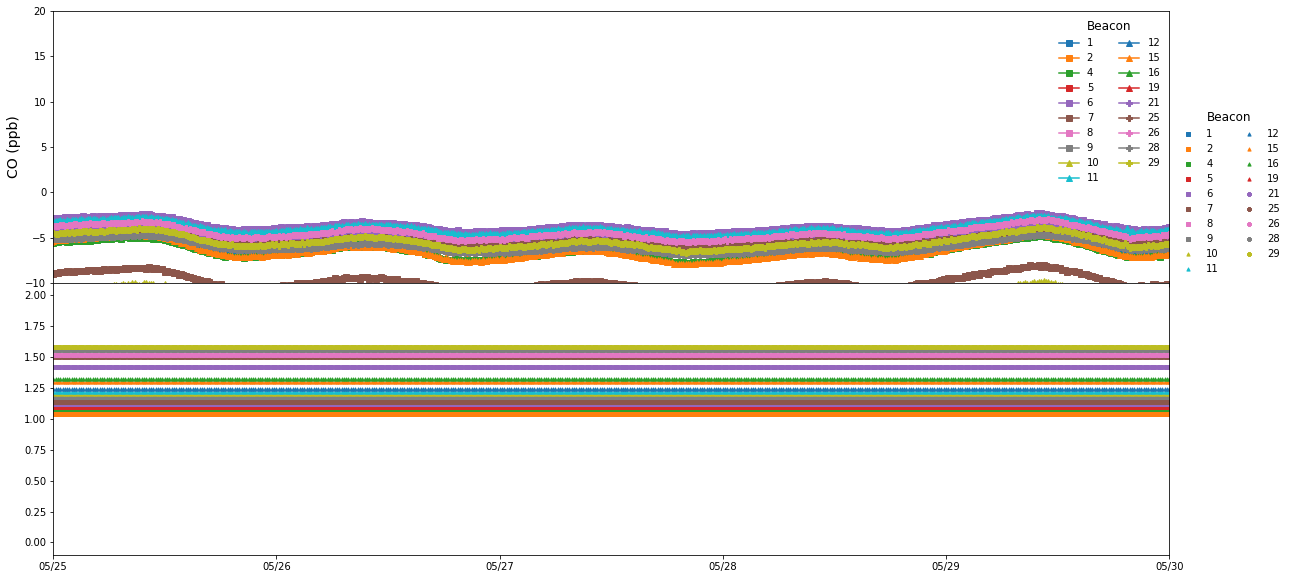

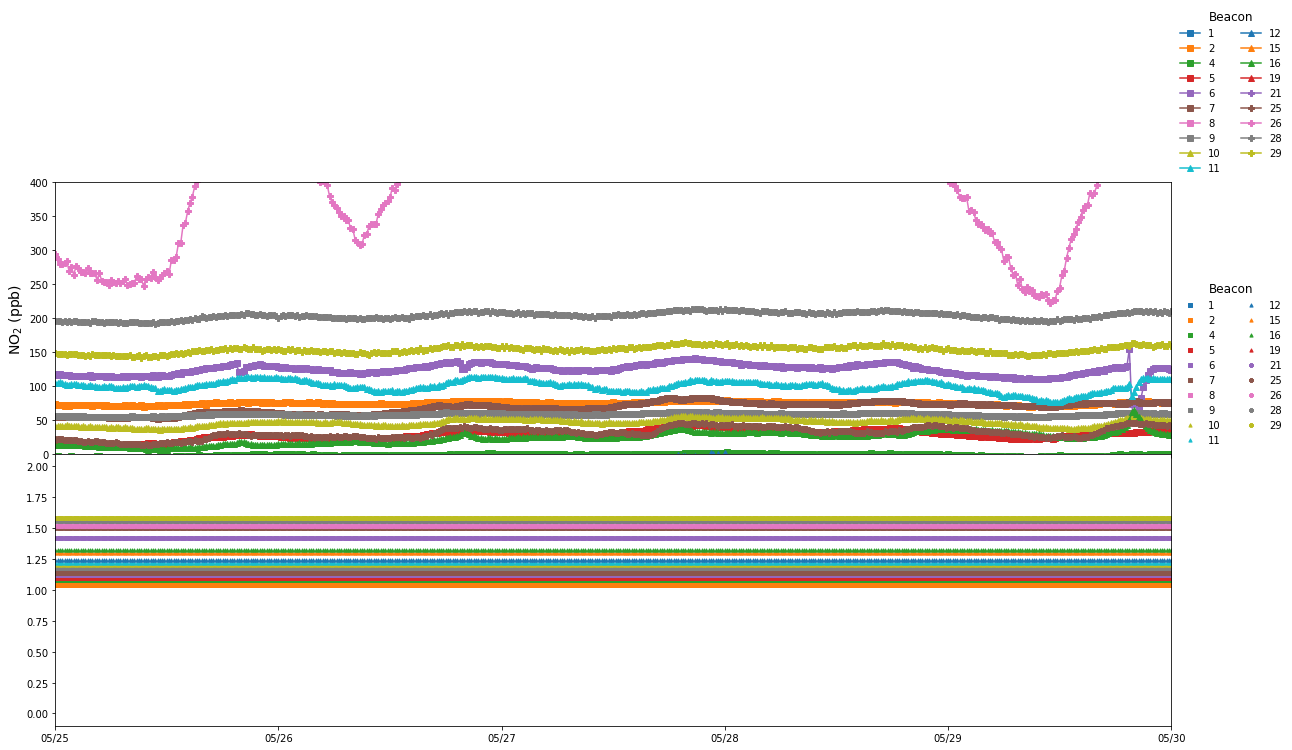

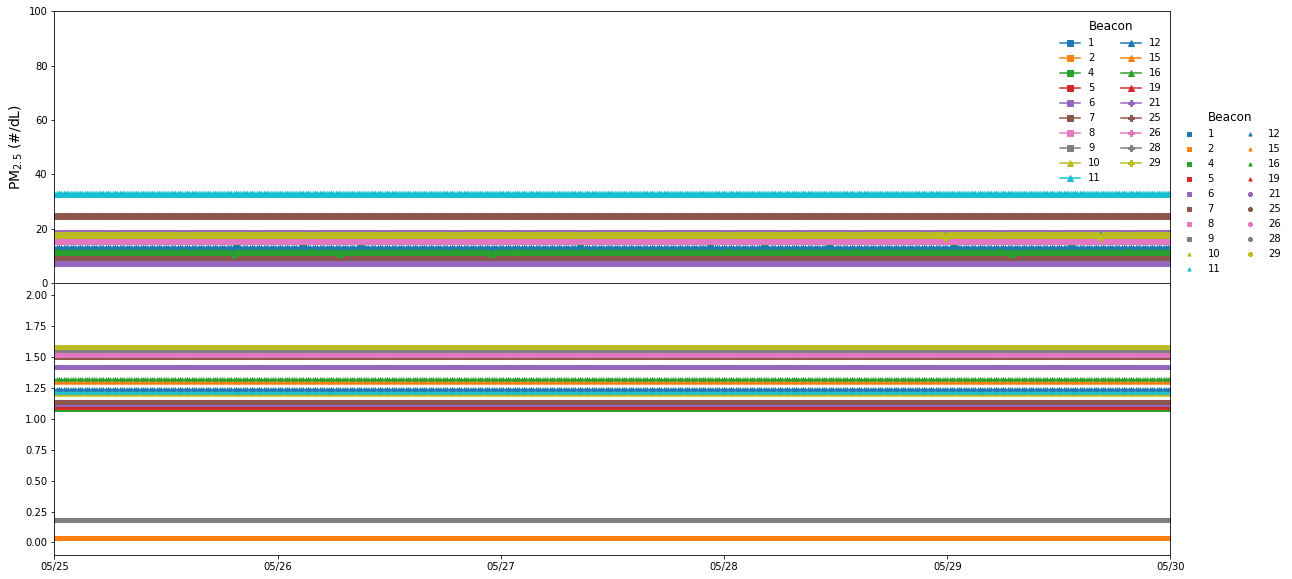

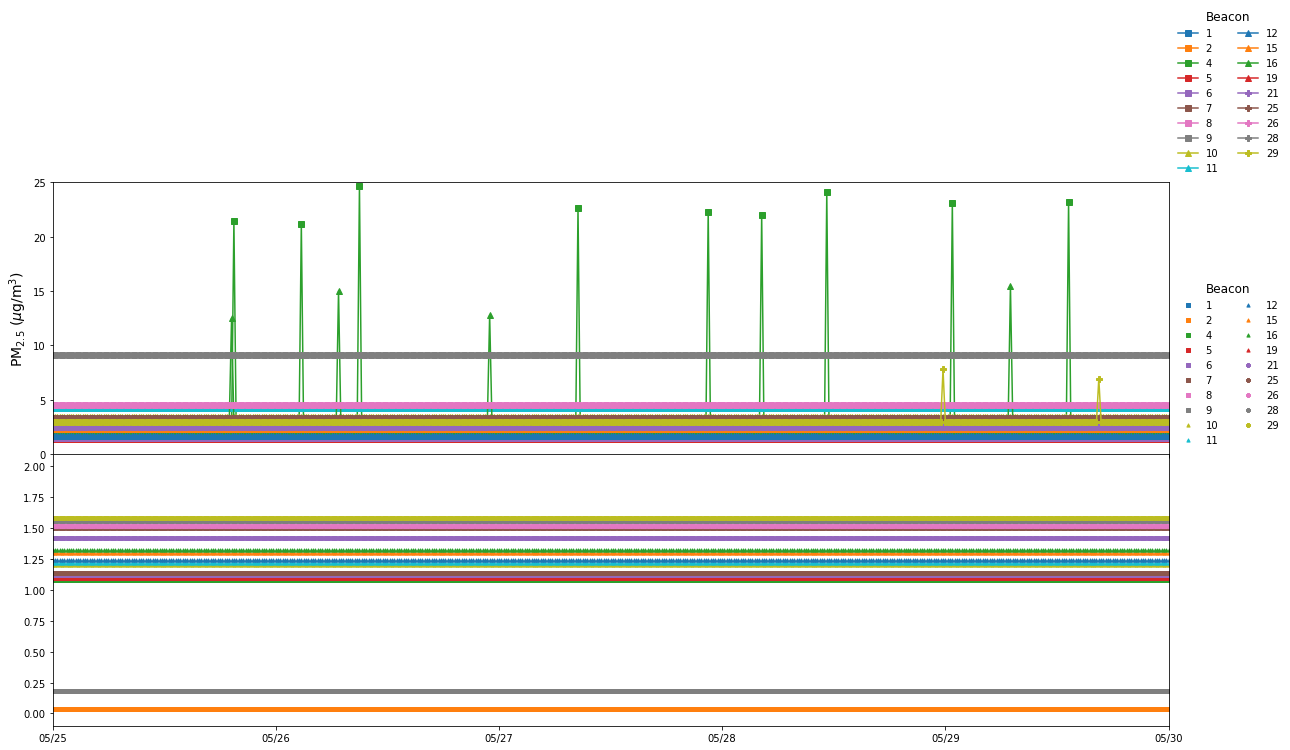

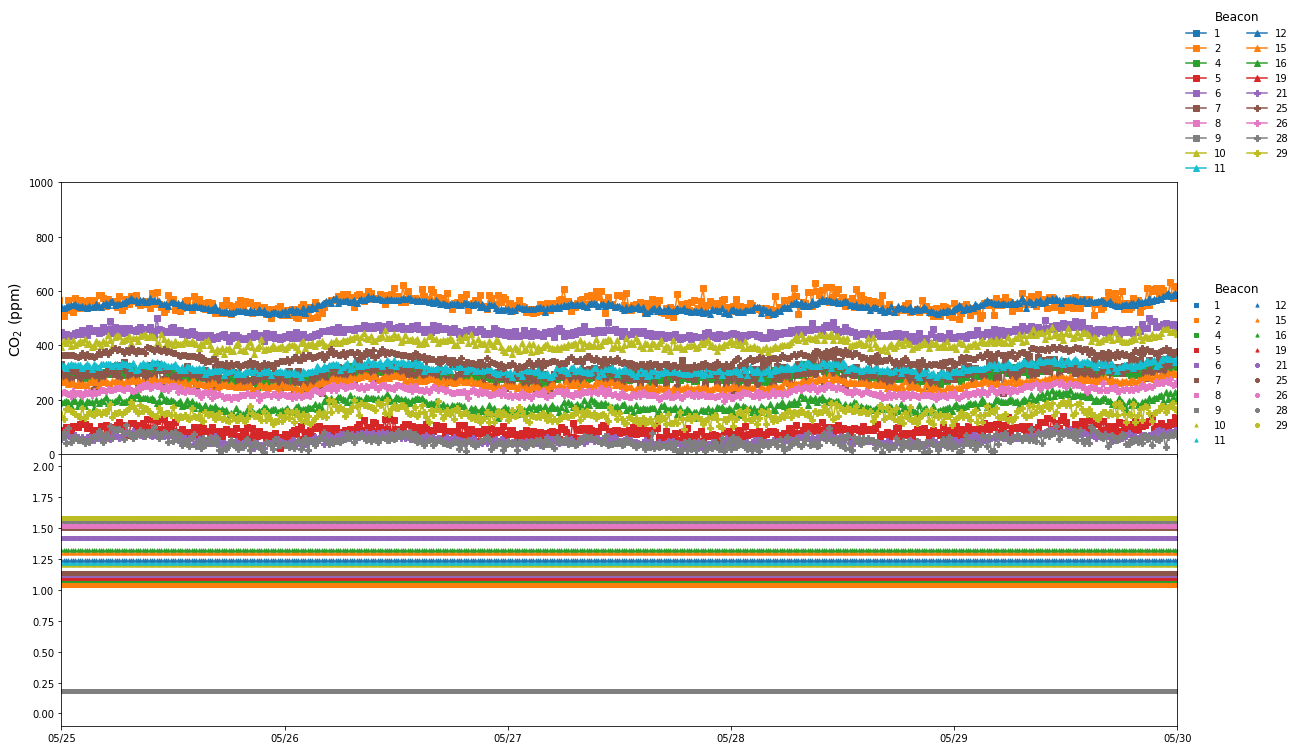

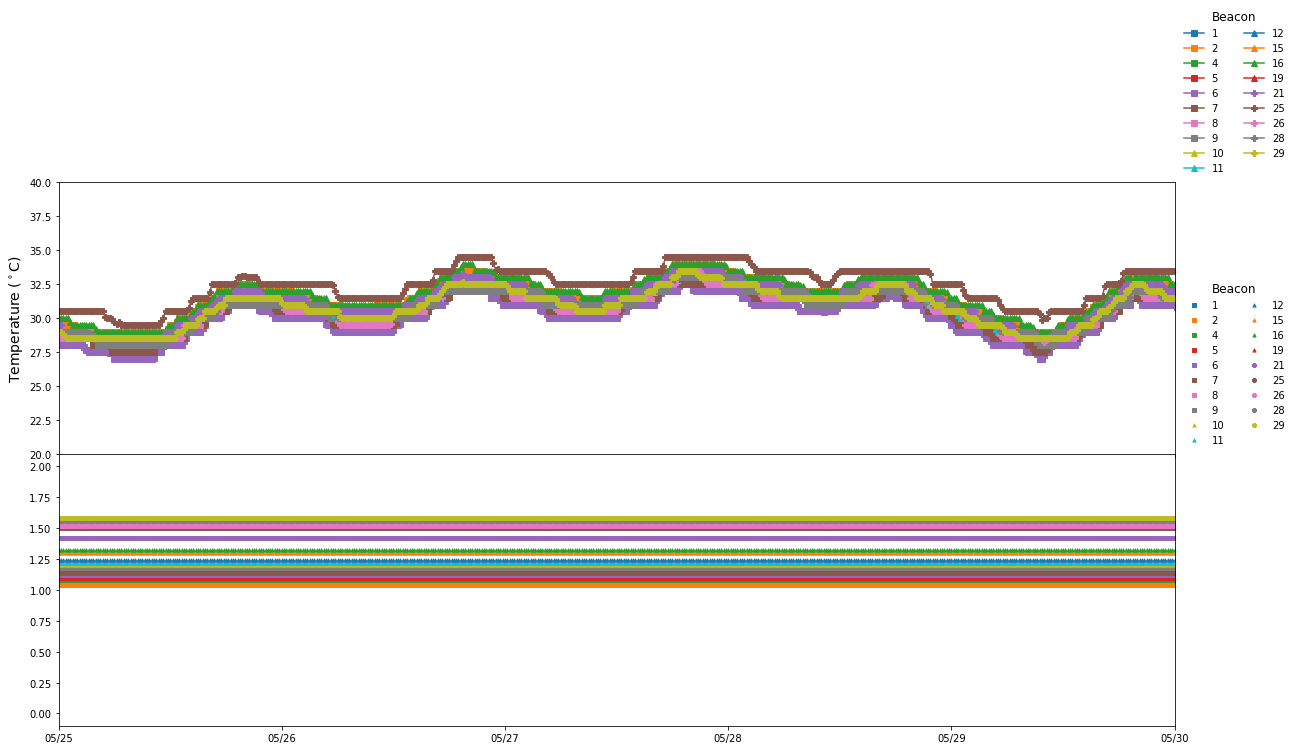

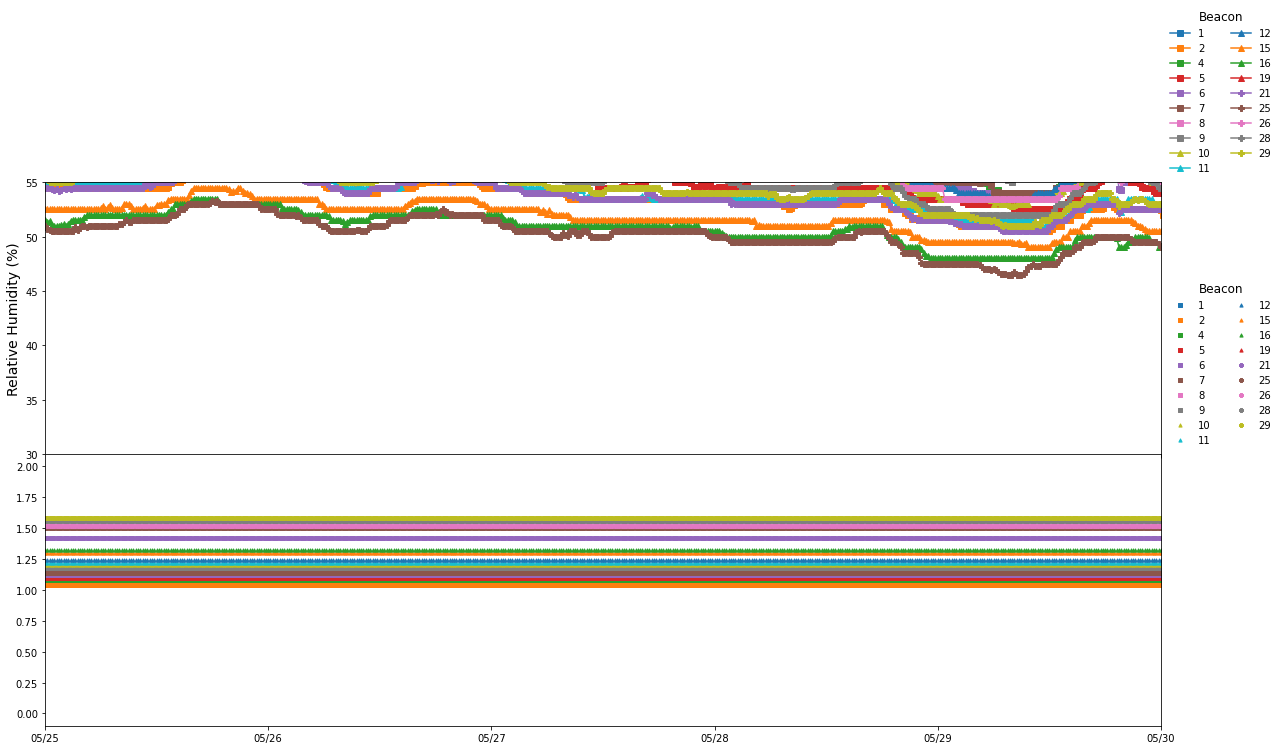

In [27]:
xleft = datetime(2021,5,25)
xright = datetime(2021,5,30)
for var, limits in zip(raw_data.columns,[[],[0,1000],[0,400],[-10,20],[0,400],[0,100],[0,25],[0,1000],[],[20,40],[30,55]]):
    if var not in ["timestamp","beacon"]:
        fig, axes = plt.subplots(2,1,figsize=(20,10),sharex=True,gridspec_kw={"hspace":0})
        for beacon in raw_data["beacon"].unique():
            data_by_beacon = raw_data[raw_data["beacon"] == beacon].set_index("timestamp")
            data_by_beacon = data_by_beacon.resample("15T").mean()
            ax = axes[0]
            ax.plot(data_by_beacon.index,data_by_beacon[var],marker=visualize.get_marker(int(beacon)),label=beacon)

            #ax.set_xlim(left=min(raw_data["timestamp"]),right=max(raw_data["timestamp"]))
            ax.set_xlim(left=xleft,right=xright)
            ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
            ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))

            ax.set_ylabel(visualize.get_pollutant_label(var) + " (" + visualize.get_pollutant_units(var) +")",fontsize=14)
            ax.set_ylim(limits)

            ax.legend(title="Beacon",ncol=2,bbox_to_anchor=(1,1),frameon=False,title_fontsize=12,fontsize=10)
            # operation
            ax = axes[1]
            data_by_beacon["op"] = data_by_beacon[var].notna()
            #print(beacon)
            #print(data_by_beacon["op"])
            ax.scatter(data_by_beacon.index,data_by_beacon["op"]+int(beacon)/50,marker=visualize.get_marker(int(beacon)),s=10,label=beacon)
            # x-axis
            ax.set_xlim(left=xleft,right=xright)
            ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
            ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
            # y-axis
            ax.set_ylim([-0.1,2.1])
            # legend
            ax.legend(title="Beacon",ncol=2,bbox_to_anchor=(1,1),frameon=False,title_fontsize=12,fontsize=10)
        
        plt.show()
        plt.close()

# Pre-Calibration
With access to higher-grade instruments, we start to look at the possibility of post-calibrating the sensors to get more-reliable results.

In [8]:
from src.calibration import calibrate

import math
import statsmodels.api as sm

## Process
The process for post-calibration is as follows:
1. **Determine Offset** (if any): Some of the sensors have a baseline that is a few (or more) units off from the true baseline. An initial _background_ calibration event should be done/used to correct the sensor to the right baseline. The offsets are saved in a file that is used when reading in the values from a certain study. 
2. **Linear Model**: 

## Experiment Details
Here are the relevant notes from the calibration experiments:
1. Experiment 1
 - **Start**: datetime(2021,5,10,14,5,0)
 - **End**: datetime(2021,5,10,23,59,0)
 - **Beacons**: [1,2,4,5,6,7,10,11,12,13,14,15,16,19,21]
 - **Events**:
     - 14:15 - 14:25: CO2 cylinder open
     - 14:25 - 14:40: Candle burning
     - 14:40 - 14:50: CO2 cylinder open
     - 14:50 - 15:05: candle burning
 - **Notes**:
     - B26 added at 14:36
2. Experiment 2
 - **Start**: datetime(2021,5,11,16,30,0)
 - **End**: datetime(2021,5,11,17,30,0)
 - **Beacons**: [1,2,4,5,6,7,10,11,12,13,14,15,16,19,21]
 - **Events**:
     - 16:35 - 17:10: Candle and paper burning
     - 16:40 - 16:55: CO2 cylinder open
     
3. Experiment 3
 - **Start**: datetime(2021,5,21,9,23,0)
 - **End**: datetime(2021,5,21,12,23,0)
 - **Beacons**: [1,2,4,5,6,7,9,10,11,12,14,15,16,19,21,23,25,26,28,29]
 - **Events**:
     - 16:35 - 17:10: Candle and paper burning

### Defining Calibration Object
We use the `Calibration` class from the UTx000 Project.

In [9]:
c = calibrate.Calibration(datetime(2021,5,21,9,23,0),datetime(2021,5,21,12,23,0),"../data/",study="wcwh_pilot",study_suffix="wcwh_s21",)

### Beacon Data
We grab the beacon data.

In [10]:
beacon = import_beacon_data(beacon_list=[1,2,4,5,6,7,9,10,11,12,14,15,16,19,21,23,25,26,28,29],start_time=c.start_time,end_time=c.end_time,resample_rate=1)
beacon.set_index("timestamp",inplace=True)

1
b01_2021-04-17.csv
b01_2021-04-16.csv
b01_2021-04-28.csv
b01_2021-04-29.csv
b01_2021-05-19.csv
b01_2021-05-18.csv
b01_2021-05-20.csv
b01_2021-05-08.csv
b01_2021-05-09.csv
b01_2021-05-21.csv
b01_2021-05-13.csv
b01_2021-05-07.csv
b01_2021-05-06.csv
b01_2021-05-12.csv
b01_2021-05-04.csv
b01_2021-05-10.csv
b01_2021-05-11.csv
b01_2021-05-05.csv
b01_2021-05-01.csv
b01_2021-05-15.csv
b01_2021-05-14.csv
b01_2021-05-16.csv
b01_2021-05-02.csv
b01_2021-05-03.csv
b01_2021-05-17.csv
b01_2021-04-24.csv
b01_2021-04-30.csv
b01_2021-04-18.csv
b01_2021-04-19.csv
b01_2021-04-25.csv
b01_2021-04-27.csv
b01_2021-04-26.csv
b01_2021-04-22.csv
b01_2021-04-23.csv
b01_2021-04-21.csv
b01_2021-04-20.csv
2
b02_2021-05-18.csv
b02_2021-05-19.csv
b02_2021-05-21.csv
b02_2021-05-09.csv
b02_2021-05-08.csv
b02_2021-05-20.csv
b02_2021-04-16.csv
b02_2021-04-17.csv
b02_2021-04-29.csv
b02_2021-04-28.csv
b02_2021-04-25.csv
b02_2021-04-19.csv
b02_2021-04-18.csv
b02_2021-04-30.csv
b02_2021-04-24.csv
b02_2021-04-26.csv
b02_2021

b21_2021-05-02.csv
b21_2021-05-18.csv
b21_2021-05-19.csv
b21_2021-05-09.csv
b21_2021-05-21.csv
b21_2021-05-20.csv
b21_2021-05-08.csv
b21_2021-04-17.csv
b21_2021-04-29.csv
b21_2021-04-28.csv
23
b23_2021-05-17.csv
b23_2021-05-03.csv
b23_2021-05-02.csv
b23_2021-05-16.csv
b23_2021-05-14.csv
b23_2021-05-15.csv
b23_2021-05-01.csv
b23_2021-05-05.csv
b23_2021-05-11.csv
b23_2021-05-10.csv
b23_2021-05-04.csv
b23_2021-05-12.csv
b23_2021-05-06.csv
b23_2021-05-07.csv
b23_2021-05-13.csv
b23_2021-04-20.csv
b23_2021-04-21.csv
b23_2021-04-23.csv
b23_2021-04-22.csv
b23_2021-04-26.csv
b23_2021-04-27.csv
b23_2021-04-19.csv
b23_2021-04-25.csv
b23_2021-04-30.csv
b23_2021-04-24.csv
b23_2021-04-18.csv
b23_2021-04-29.csv
b23_2021-04-28.csv
b23_2021-04-17.csv
b23_2021-05-09.csv
b23_2021-05-21.csv
b23_2021-05-20.csv
b23_2021-05-08.csv
b23_2021-05-18.csv
b23_2021-05-19.csv
25
b25_2021-05-11.csv
b25_2021-05-13.csv
b25_2021-05-12.csv
b25_2021-05-16.csv
b25_2021-05-17.csv
b25_2021-05-15.csv
b25_2021-05-14.csv
b25_20

### Reference Instrument Data
All data are saved as dataframes in a dictionary indexed by the pollutant type

In [11]:
# experiment 1 offset
#t_offset = datetime(2021,5,10,14,5,0) - datetime(2021,5,10,12,58,22)
# experiment 2 offset
t_offset = datetime(2021,5,11,16,30,0) - datetime(2021,5,11,15,23,0)

In [12]:
ref = {}
for pollutant, f in zip(["pm_number","pm_mass","no2","co2","co"],[c.get_pm_ref,c.get_pm_ref,c.get_no2_ref,c.get_co2_ref,c.get_zero_baseline]):
    print("reading for", pollutant)
    if pollutant[:3] in ["pm_","co2"]:
        ref[pollutant] = f(file=f"{pollutant}_{c.date}.csv",resample_rate=1,minute_offset=t_offset.seconds/60)
    elif pollutant[:3] == "no2":
        ref[pollutant] = f(file=f"{pollutant}_{c.date}.csv",resample_rate=1,minute_offset=t_offset.seconds/60)
    else:
        ref[pollutant] = f(file=f"{pollutant}_{c.date}.csv",resample_rate=1)

reading for pm_number
reading for pm_mass
reading for no2
reading for co2
reading for co


## Inspection
Some simple functions to inspect measurements

### Reference Measurements

In [13]:
#c.inspect(ref["pm_concentration"][["PM_2p5"]])
#c.inspect(ref["co2"])
#c.inspect(beacon[["PM_N_2p5","Beacon"]],timeseries=False)

### Beacon Measurements

In [14]:
##bb = "05"
##df = pd.read_csv(f"../data/raw/utx000/beacon/B{bb}/sensirion/b{bb}_2021-01-12.csv",index_col=0,parse_dates=True)
##c.inspect(df[["CO2"]])

## Calibration of Pollutants with Reference
In this section, we take a look at correcting the low-cost sensors to the reference machines in three ways:
1. Constant/Offset
2. Linear Regression
3. Random Forest

The following sections are first broken down by pollutant and then by method.

In [15]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

### Details
The cells below should be edited to correspond to the pollutant of interest:
- **no2**: [SPEC DGS NO2](https://www.spec-sensors.com/wp-content/uploads/2017/01/DGS-NO2-968-043_9-6-17.pdf)
- **co**: [SPEC DGS CO](https://www.spec-sensors.com/wp-content/uploads/2017/01/DGS-CO-968-034.pdf)
- **co2**:

In [16]:
pollutant = "no2"

### Non-Responsive Beacons
The ```get_reporting_beacons``` functions determines which of the beacons that was included in the calibration event are not shown in the following figures because of issues related to power, sensor connection, or VPN connection.

In [17]:
missing, reporting = c.get_reporting_beacons(beacon,pollutant)

Missing data from: []


### Time Series Comparison

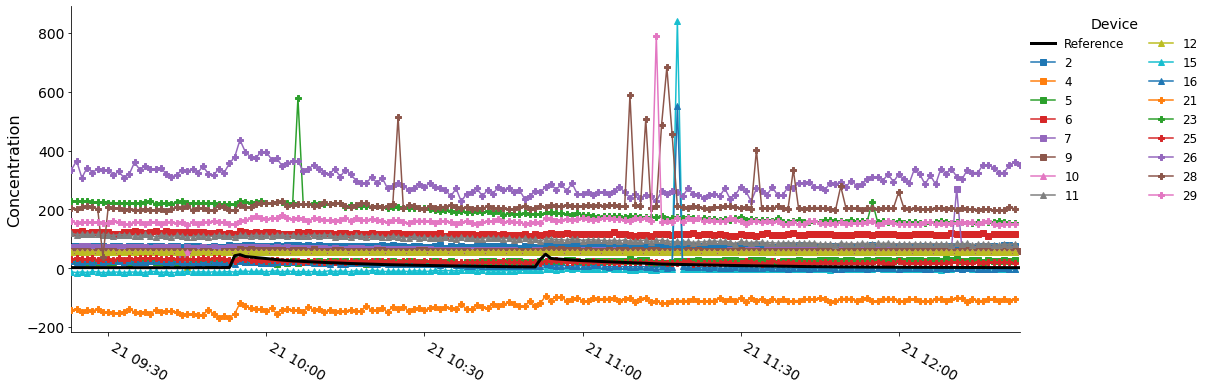

In [18]:
c.compare_time_series(ref[pollutant],beacon[[pollutant,"beacon"]])

### Comparing Histograms
Now we look at each individual beacon and compared the histograms

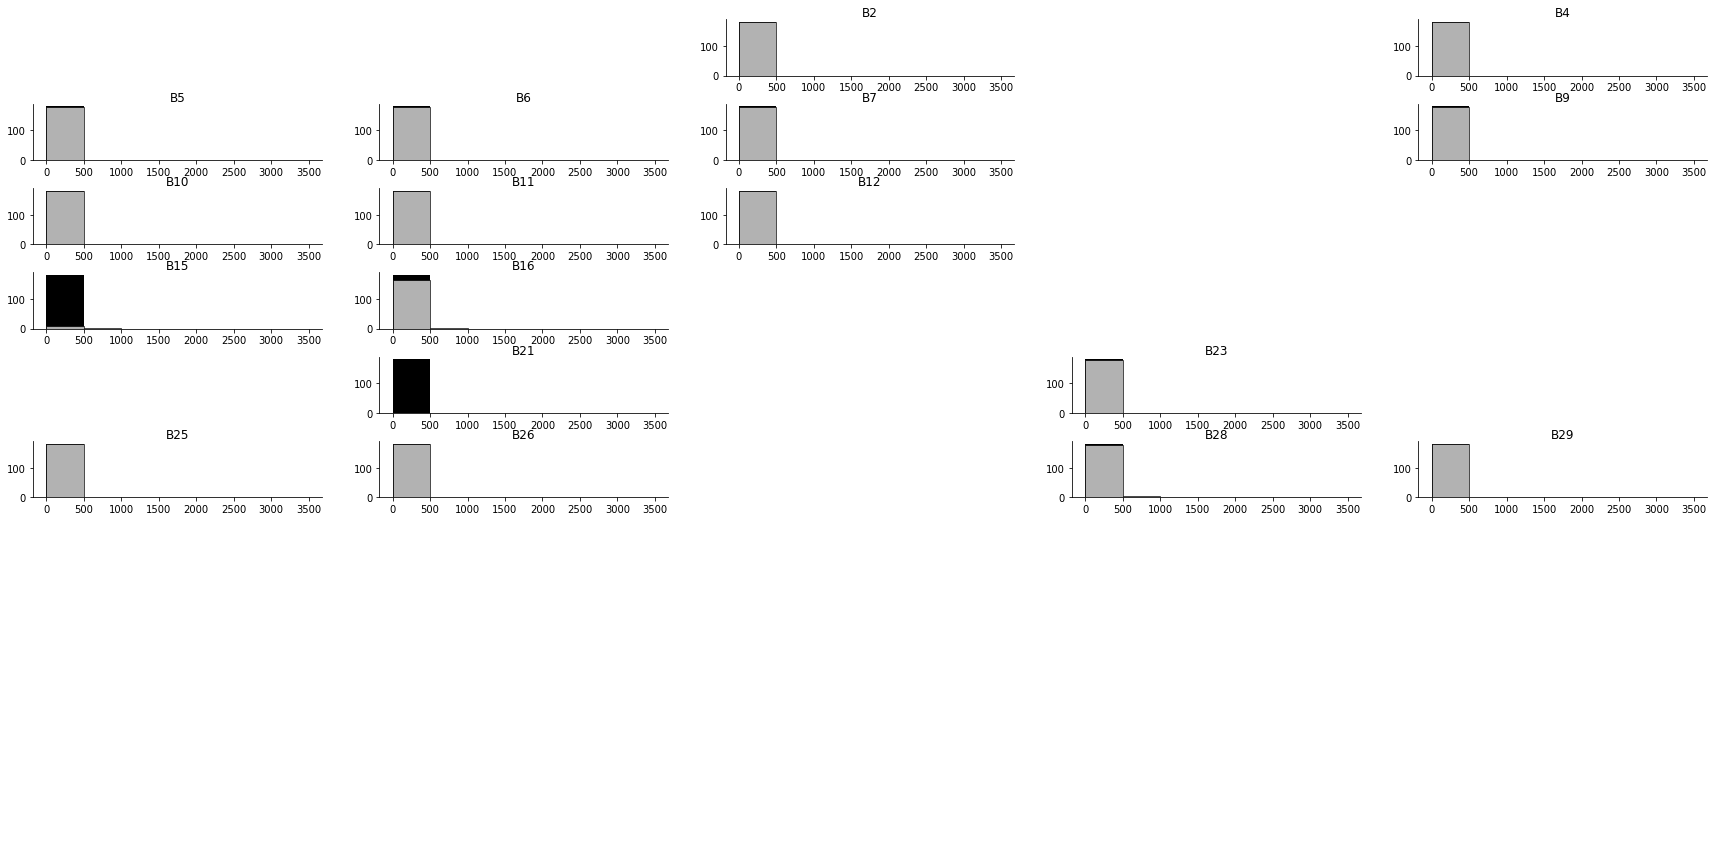

In [19]:
c.compare_histogram(ref[pollutant],beacon[[pollutant,"beacon"]],bins=np.arange(0,4000,500))

### Constant/Offset
The simplest method, and one that might show promise for this sensor, is simply to offset the measurement by a constant. We start by looking at the differences between each beacon with an NO2 sensor and the reference machine.

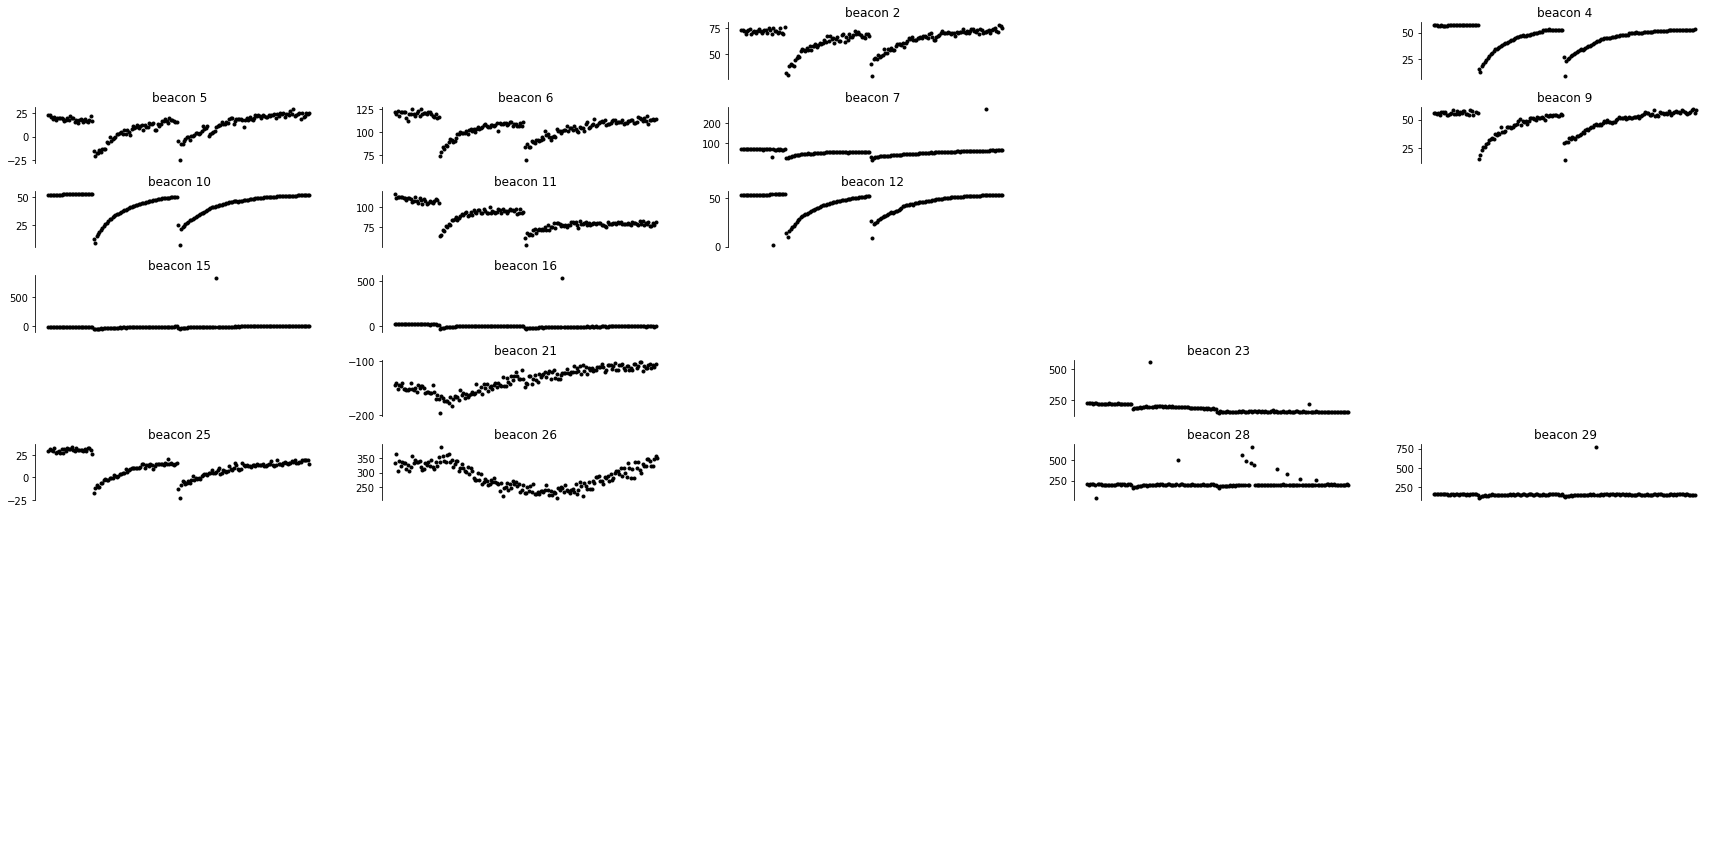

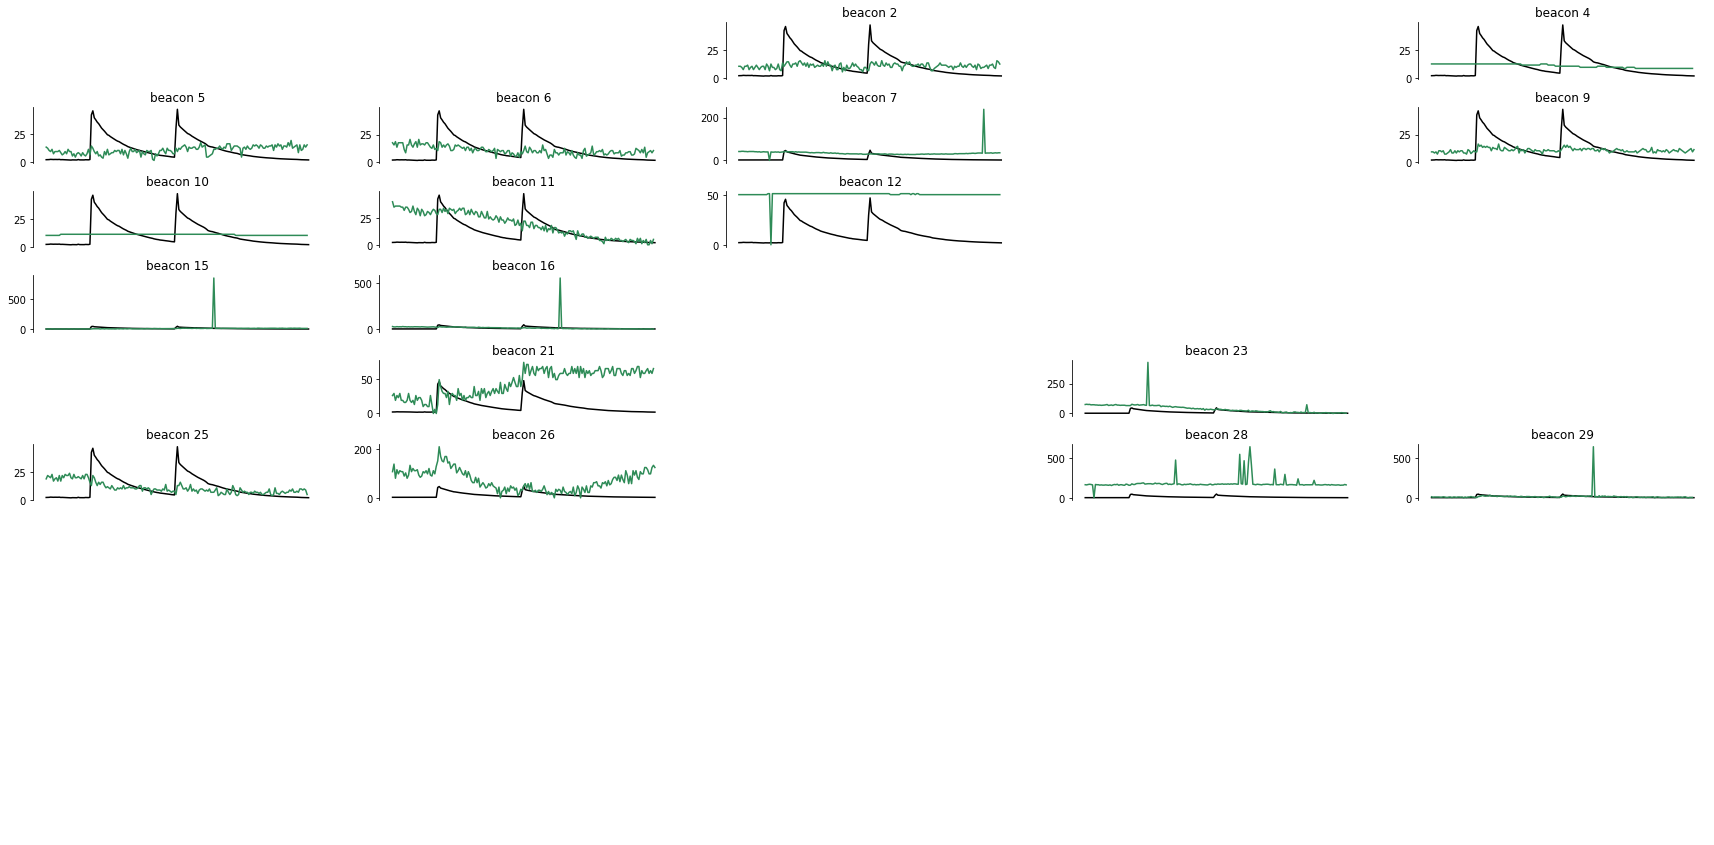

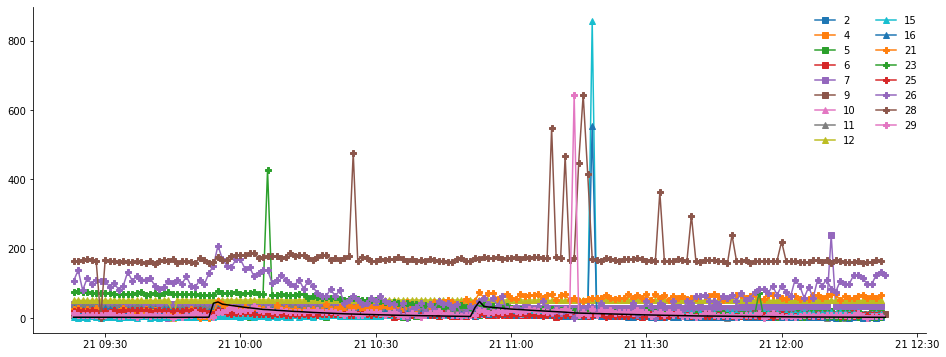

In [20]:
offset = c.offset(ref, beacon, pollutant, pollutant, save_to_file=False, show_corrected=True)

### Linear Model

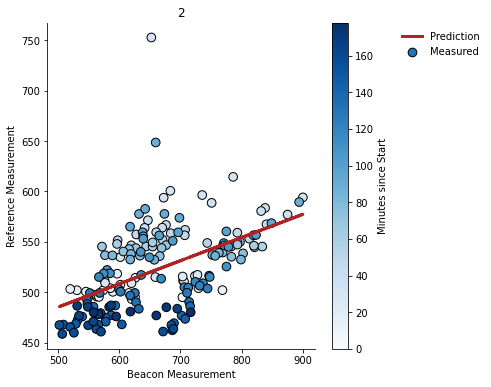

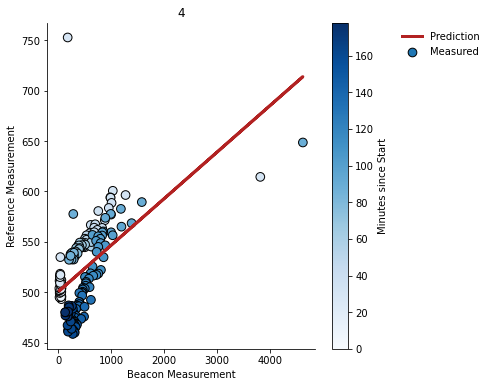

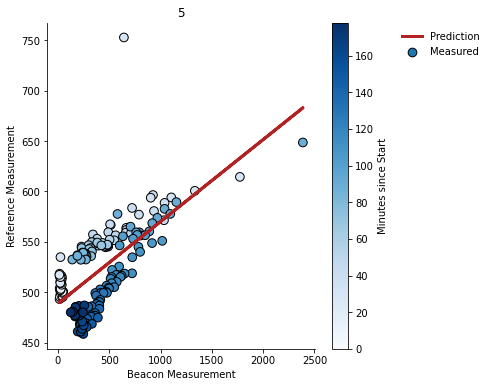

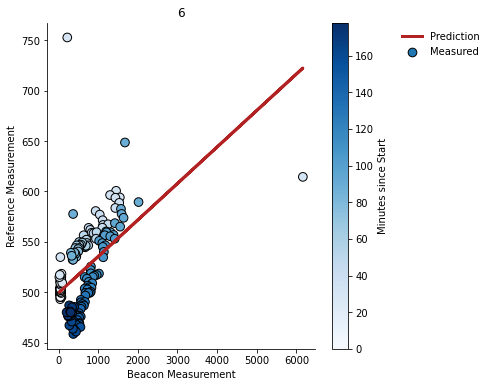

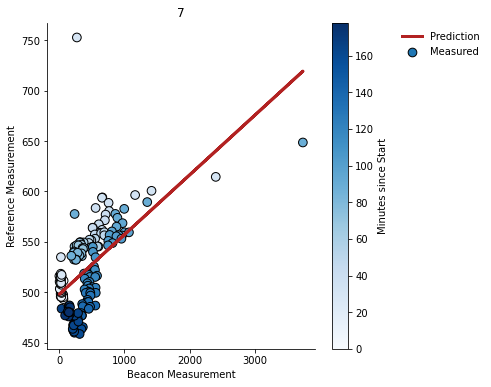

Error with data.


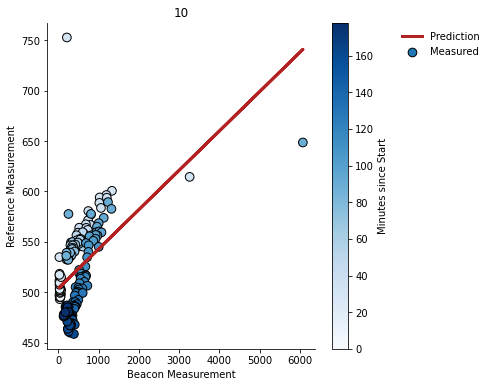

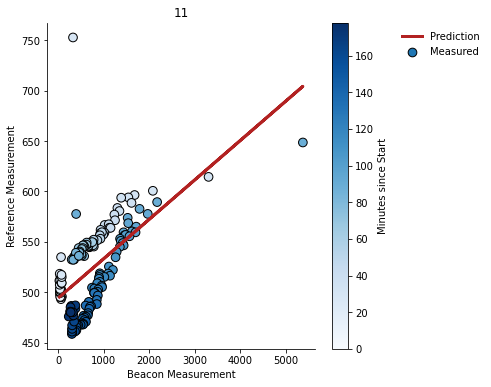

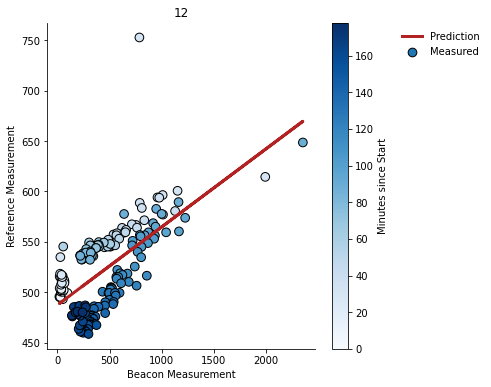

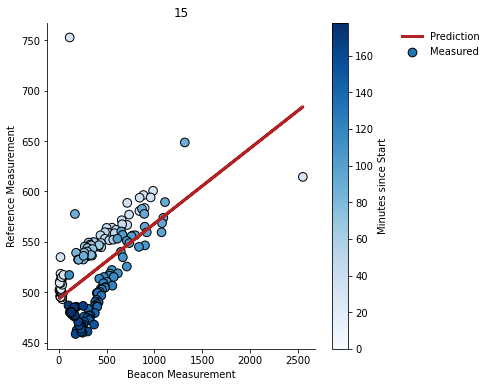

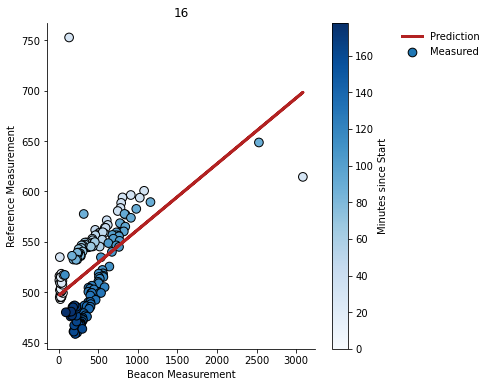

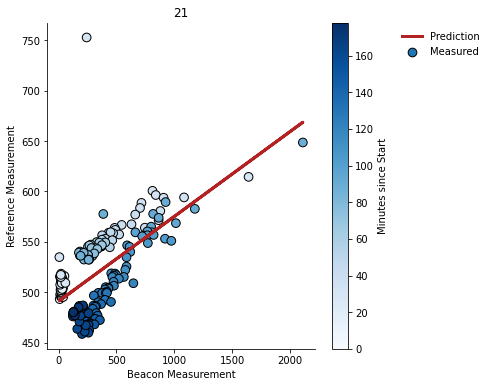

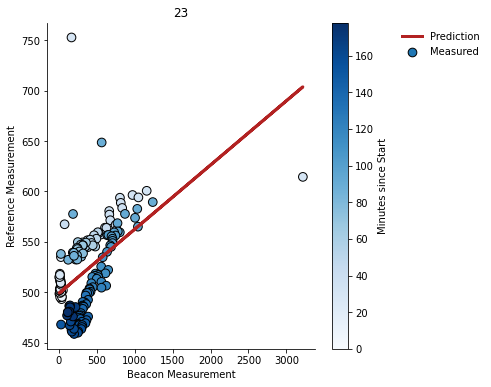

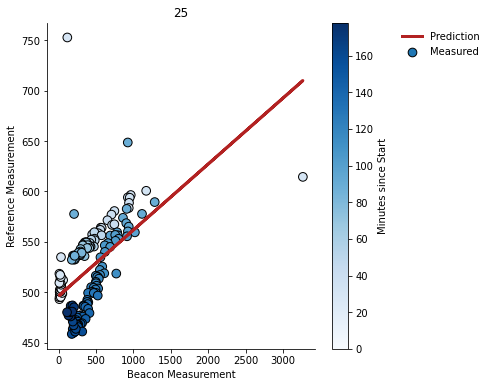

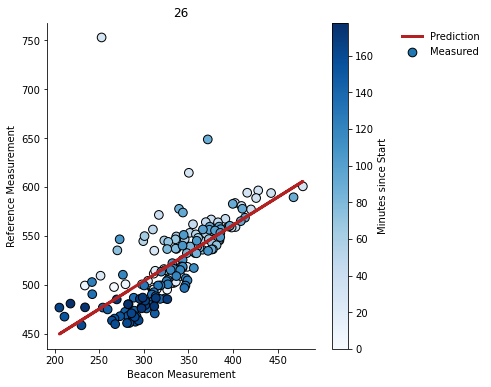

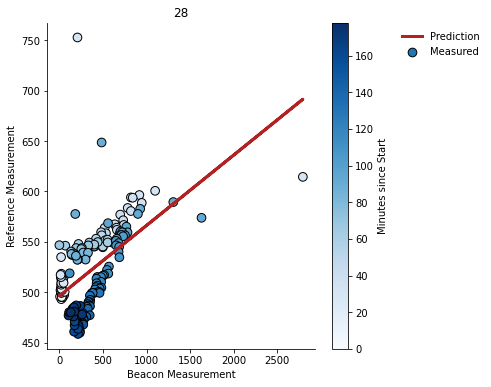

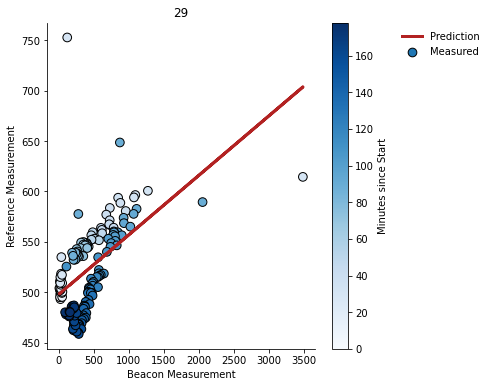

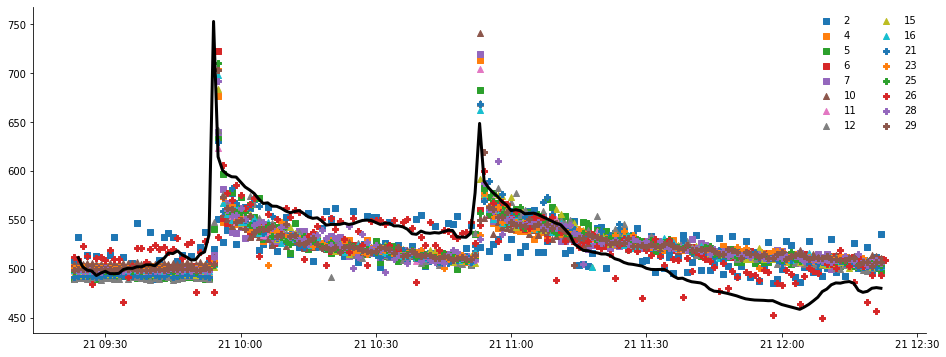

In [79]:
m = c.linear_regression(ref, beacon, pollutant, pollutant,verbose=False,save_to_file=True,show_plot=True,show_corrected=True)

## Particulate Matter
We look at the calibration of PM in a different set of cells due to the reference format. 

In [73]:
size = "2p5"
measurement = "mass"

### Time Series Comparison

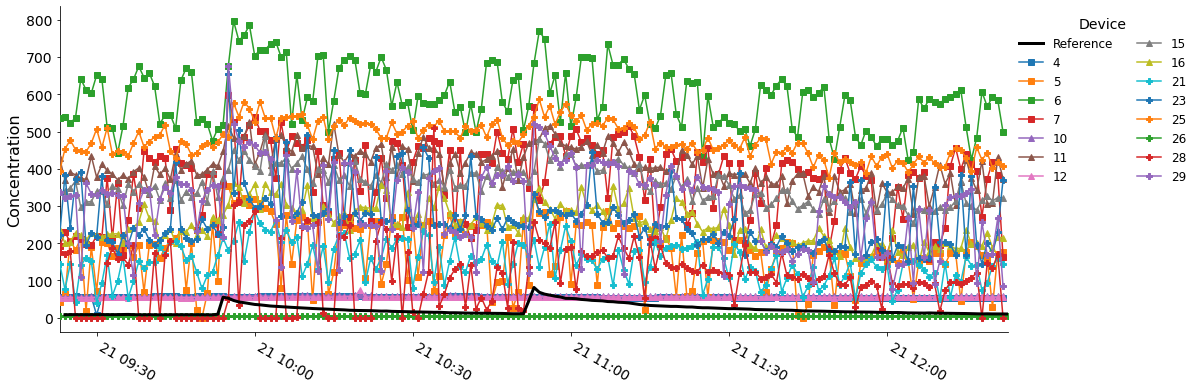

In [74]:
c.compare_time_series(ref[f"pm_{measurement}"][[f"pm{size}"]],beacon[[f"pm{size}_{measurement}","beacon"]])

### Histogram Comparison

In [107]:
#c.compare_histogram(ref[f"pm_{measurement}"][[f"pm{size}"]],beacon[[f"pm{size}_{measurement}","beacon"]],bins=np.arange(0,21,1))

Based on the results, it does not seem like there is a good constant offset that we can apply to correct the data. In fact, many of the beacons seem to exhibit the same pattern and are colored accordingly.

### Constant/Offset

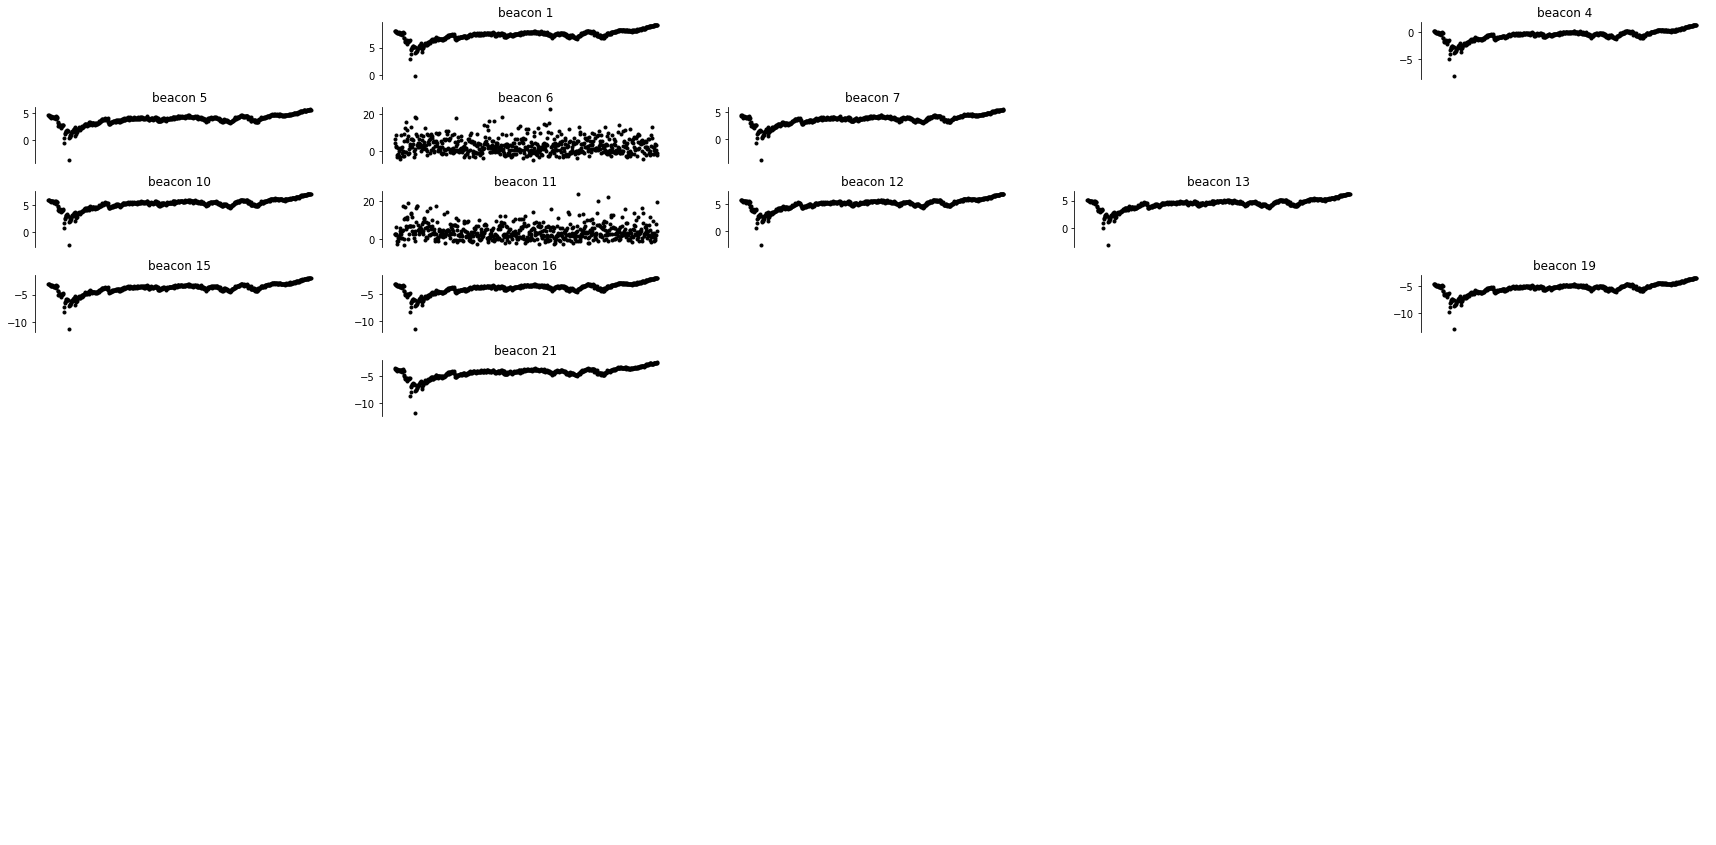

In [108]:
pm_mass = ref[f"pm_{measurement}"]
pm_mass[f"concentration"] = pm_mass[f"pm{size}"]
ref[f"pm_{measurement}"] = pm_mass
pm_offset = c.offset(ref, beacon, f"pm_{measurement}", f"pm{size}_{measurement}",save_to_file=False,show_corrected=False)

### Linear Model

Error with data.


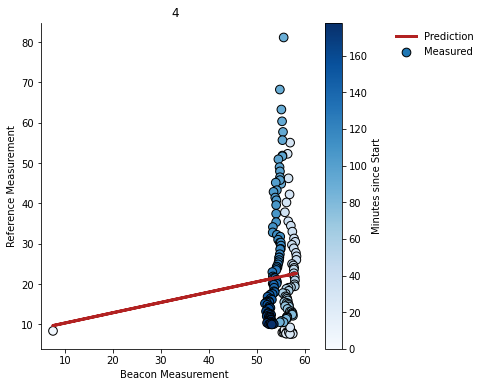

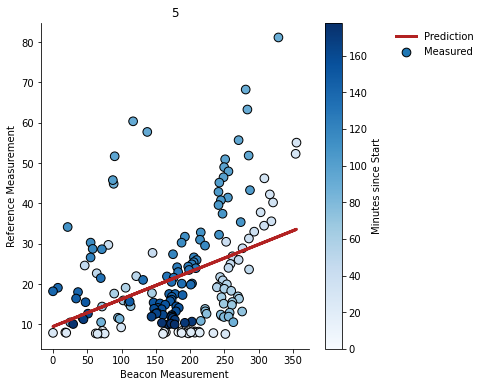

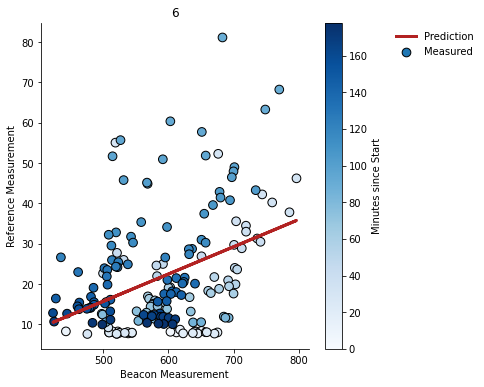

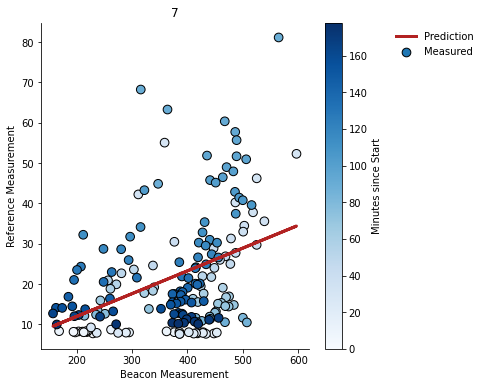

Error with data.


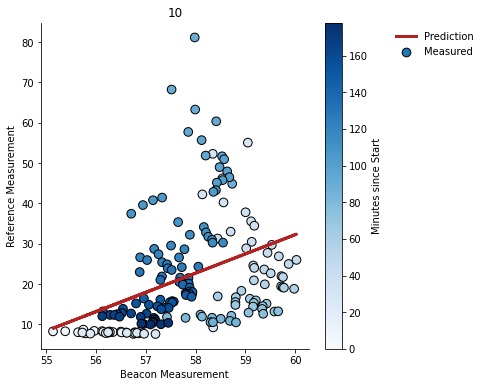

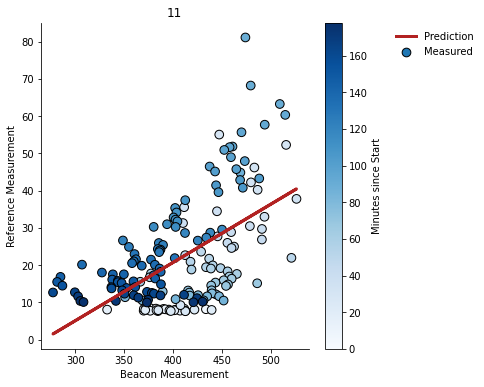

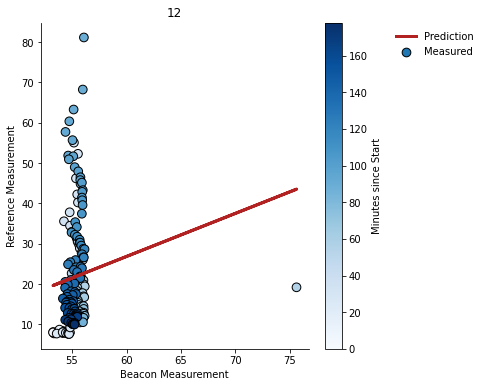

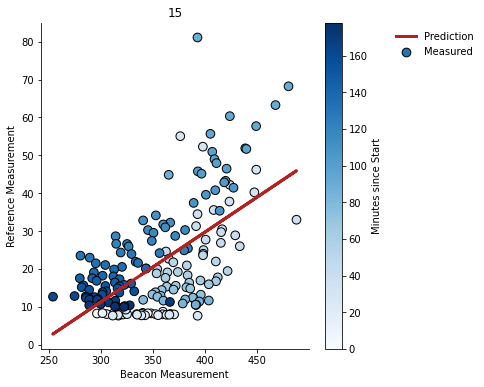

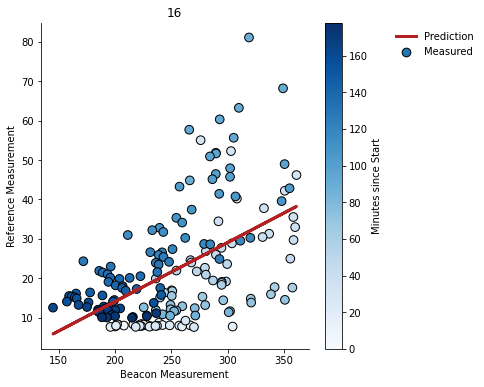

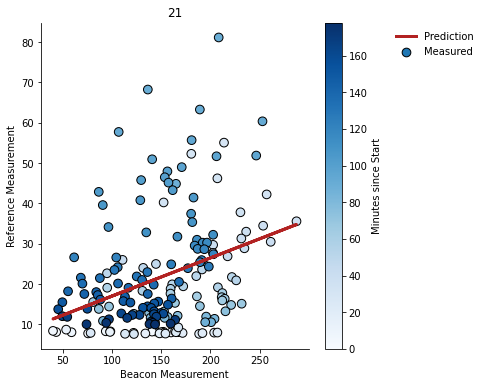

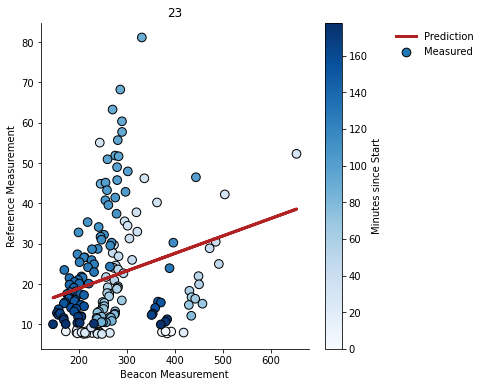

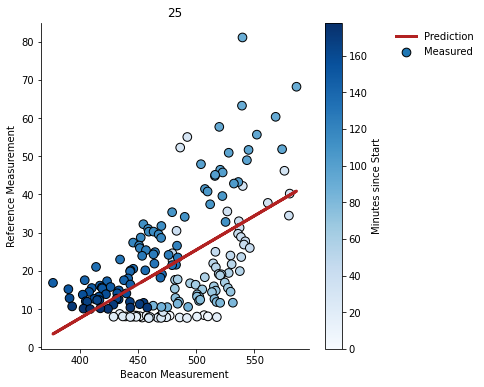

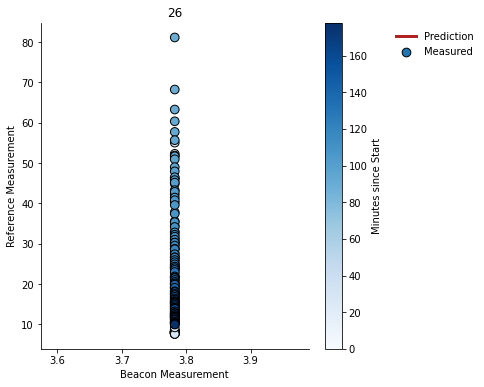

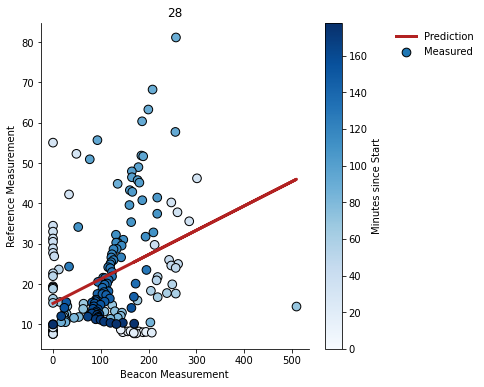

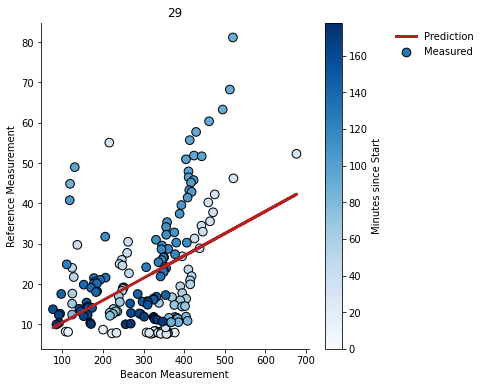

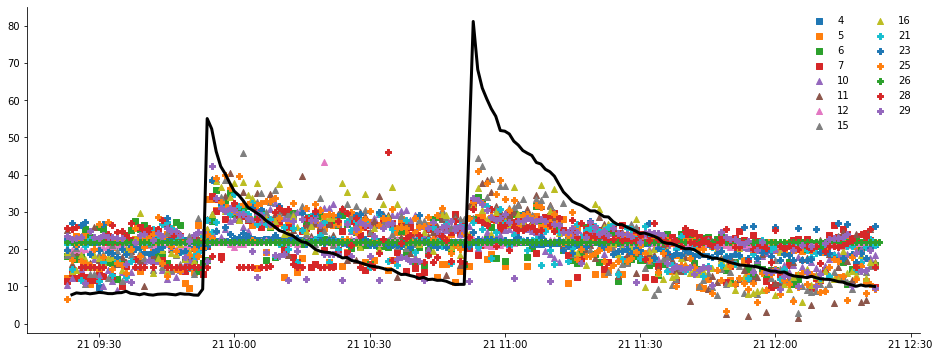

In [75]:
pm_mass = ref[f"pm_{measurement}"]
pm_mass["concentration"] = pm_mass[f"pm{size}"]
ref[f"pm_{measurement}"] = pm_mass
pm_lm = c.linear_regression(ref, beacon, f"pm_{measurement}", f"pm{size}_{measurement}",verbose=False,save_to_file=False,show_plot=True,show_corrected=True)